<a href="https://colab.research.google.com/github/maricamolesi/Iniciacao-Cientifica/blob/master/Rede_Neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# License: BSD
# Author: Sasank Chilamkurthy
# Modified: Mariana Camolesi

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torch.utils import data
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode


**CARREGANDO A BASE DE DADOS**

Neste notebook foi utilizado o banco de imagens Brodatz 128x128 contendo 1776 imagens de textura, com leve corrosão (pelo código dos Autômatos Celulares; parâmetros v = 10, gamma = 0.01 e 30 iterações). O conjunto foi dividido em treinamento e validação na proporção meio a meio, de forma aleatória.



In [13]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/My Drive/ProjetoIC/trainval_v10gamma001int20'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=12,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



**VISUALIZAÇÃO DE ALGUMAS IMAGENS DO TREINAMENTO**

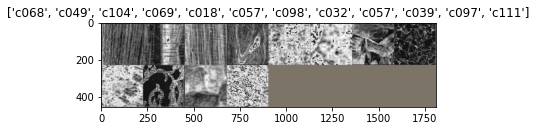

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

**TREINAMENTO DO MODELO**



In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

**AJUSTE FINO DA REDE**

Uso da rede neural ResNet50 pré treinada.

In [26]:
#Finetuning the convnett
model_ft = models.resnet101(pretrained=True)
num_ftrs = model_ft.fc.in_features

# The size of each output sample is len(class_names)
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.002, momentum=0.9)

# Decay LR by a factor of 0.6 every 9 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=9, gamma=0.5)



In [27]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 4.1310 Acc: 0.1547
val Loss: 2.1194 Acc: 0.6372

Epoch 1/24
----------
train Loss: 1.9972 Acc: 0.5482
val Loss: 0.7478 Acc: 0.8018

Epoch 2/24
----------
train Loss: 1.1210 Acc: 0.7152
val Loss: 0.4829 Acc: 0.8555

Epoch 3/24
----------
train Loss: 0.8613 Acc: 0.7747
val Loss: 0.3566 Acc: 0.8981

Epoch 4/24
----------
train Loss: 0.6649 Acc: 0.8274
val Loss: 0.3401 Acc: 0.8936

Epoch 5/24
----------
train Loss: 0.6108 Acc: 0.8206
val Loss: 0.2979 Acc: 0.9160

Epoch 6/24
----------
train Loss: 0.5084 Acc: 0.8531
val Loss: 0.2899 Acc: 0.9227

Epoch 7/24
----------
train Loss: 0.4525 Acc: 0.8733
val Loss: 0.2899 Acc: 0.9093

Epoch 8/24
----------
train Loss: 0.3656 Acc: 0.9013
val Loss: 0.1812 Acc: 0.9496

Epoch 9/24
----------
train Loss: 0.2982 Acc: 0.9238
val Loss: 0.1445 Acc: 0.9642

Epoch 10/24
----------
train Loss: 0.2487 Acc: 0.9473
val Loss: 0.1530 Acc: 0.9675

Epoch 11/24
----------
train Loss: 0.2163 Acc: 0.9462
val Loss: 0.1251 Acc: 0.9698

Ep